<a href="https://colab.research.google.com/github/lucascviana/Meus-Projetos/blob/main/Pol%C3%ADticas_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construção de políticas de Crédito com ML

#### Uso do caso do Kaggle - Landing Club

In [3]:
# Importe a classe Path do módulo pathlib
from pathlib import Path

# Crie um objeto Path a partir do diretório de trabalho atual
cwd = Path.cwd()

# Junte o diretório de trabalho atual com o caminho relativo "../../"
path = cwd / "../../"

# Mude o diretório de trabalho atual para o novo caminho
os.chdir(path)

# Obter o diretório do trabalho atual
print(os.getcwd())

/


In [ ]:
## Imortando bibliotecas

In [ ]:
#manipulação do df
import pandas as pd
import numpy as np


#machine learning
from sklearn.model_selection import train_test_split
!pip install lightgbm
from lightgbm import LGBMClassifier #interface de classificação binária ou mutipla a partir de variáveis

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

!pip install matplotlib
!pip install matplotlib_venn
#visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

primary_color = '#6938d4'
analog_color  = '#3855d4'
analog_color2 = '#b7738d4'
sec_color = '#a3d438'

error_color = '#C62828'

tria_color = '#d438a3'
tria_color = '#d46938'

sns.set(style="ticks", context="talk")
plt.style.use(['dark_background'])
gray_label_bg = '#E0E0E0'
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5, "lines.linewidth": 1.5, "xtick.labelsize": 11, "ytick.labelsize": 11, "font.size": 14,
                     "axes.labelsize": 15,
                     "xtick.color": gray_label_bg,
                     "ytick.color": gray_label_bg,
                     "axes.facecolor": '#121212',
                     "axes.edgecolor" : gray_label_bg,
                     "axes.labelcolor" : gray_label_bg,
                     "figure.facecolor" : '#121212',
                     #figure.edgecolor
                     "axes.axisbelow": 'false',
                     "axes.linewidth": 0.8,
                     "xtick.major.bottom": "true",
                     })

In [ ]:
##Carregando  dataset

In [ ]:
!pip install pyarrow
df_raw = pd.read_feather('Documents/ML/landingclub/lending_club_smaller_sample.feather')
df_raw = df_raw.rename(columns={'bad_payer':'default'})
df_raw.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,default
0,78428548,6400,6400,6400.0,36,0.1367,217.720001,C,C3,Web Support Analist,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0
1,136264733,35000,35000,35000.0,36,0.1691,1246.280029,C,C5,Vice President,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,1.0
2,141294472,10000,10000,10000.0,36,0.1797,361.380005,D,D1,Dispatcher 3,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0
3,95218480,35000,35000,35000.0,36,0.1049,1137.430054,B,B2,Emergency Physician,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0
4,112117439,3500,3500,3500.0,36,0.1091,114.440002,B,B4,Grocery,...,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N,0.0


## Distribuição das variáveis de interesse -

In [ ]:
#exploração dos números
print (df_raw.default.value_counts(normalize= True)*100)
print (df_raw.default.value_counts)

default
0.0    80.5115
1.0    19.4885
Name: proportion, dtype: float64
<bound method IndexOpsMixin.value_counts of 0         0.0
1         1.0
2         0.0
3         0.0
4         0.0
         ... 
199995    1.0
199996    0.0
199997    1.0
199998    0.0
199999    0.0
Name: default, Length: 200000, dtype: float64>


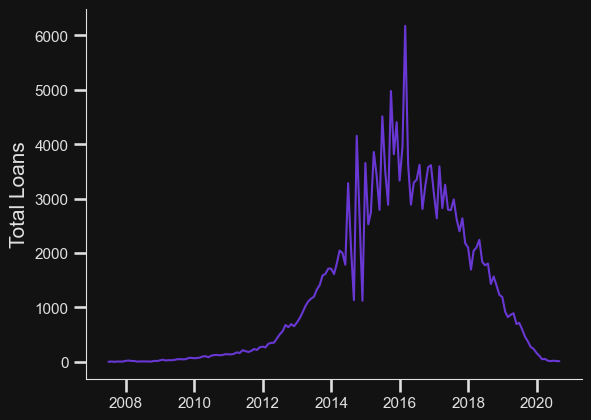

In [ ]:
#contagem por data
df_gp = df_raw.groupby('issue_d')['id'].count().reset_index()
df_gp

ax = sns.lineplot(df_gp, x='issue_d',y='id', color = primary_color)
plt.xlabel("")
plt.ylabel('Total Loans')
sns.despine()

plt.show()


In [ ]:
default_ratio = df_raw.default.value_counts(normalize=True)[1]
print('default_ration', default_ratio)

default_ration 0.194885


## Organizando as features
### Removendo as colunas sem uso, uasr apenas variáveis presentes no momento de credt application

In [ ]:
df = df_raw.copy()
# Lista de colunas com dados coletados após a concessão do crédito, ou seja, após o processo de aplicação (application)
after_grant_cols= ['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low',
                   'last_fico_range_high','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                   'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','tot_coll_amt','last_pymnt_amnt',
                   'total_il_high_credit_limit', 'hardship_flag', 'installment',
                   'revol_util','collections_12_mths_ex_med',
                   #duvida
                   'last_credit_pull_d', 'next_pymnt_d', 'last_pymnt_d', 'collection_recovery_fee'
                   ]

# Removendo as variáveis relacionadas ao plano de dificuldades (covid)
# https://structuredfinance.org/resource-details/helping-consumers-bridge-financial-hardship/
hardship_cols = ['hardship_flag','hardship_type','hardship_reason','hardship_status','deferral_term',
                 'hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date',
                 'hardship_length','hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest',
                 'hardship_payoff_balance_amount','hardship_last_payment_amount','debt_settlement_flag']

useless_cols = ['id', 'initial_list_status', 'title', 'purpose', 'url', 'pymnt_plan', 'loan_status', 'emp_title']

date_cols = list(df.select_dtypes(include='datetime').columns)

# Colunas a serem dropadas
cols_to_drop = after_grant_cols + hardship_cols + useless_cols + date_cols

# feature columns
feature_cols = df_raw.drop(columns=cols_to_drop + ['default']).columns

# Removendo as colunas do dataset
df = df_raw[feature_cols].copy()





## Splitando o dataset temporalmente (out-of-time)

In [ ]:
#inclusão de uma coluna e rótulo para as linhas
train_df, test_df = np.split(df_raw.sort_values(by='id'),[int(.80*len(df_raw))])
train_df['set_type'] = 'train'
test_df['set_type'] = 'test'

In [ ]:
print('Train default ratio')
print(train_df.default.value_counts(normalize=True) * 100)
print(train_df.default.value_counts())

print()
print('Test default ratio')
print(test_df.default.value_counts(normalize=True) * 100)
print(test_df.default.value_counts())

Train default ratio
default
0.0    81.17375
1.0    18.82625
Name: proportion, dtype: float64
default
0.0    129878
1.0     30122
Name: count, dtype: int64

Test default ratio
default
0.0    77.8625
1.0    22.1375
Name: proportion, dtype: float64
default
0.0    31145
1.0     8855
Name: count, dtype: int64


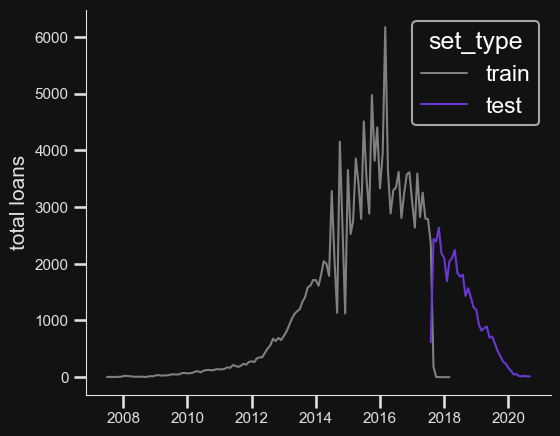

In [ ]:
#plotando o gráfico - comum usar o reset index após um group buy
df_gp = pd.concat([train_df, test_df])
df_gp = df_gp.groupby(['issue_d', 'set_type'])['id'].count().reset_index() #agrupamento e soma/contagem dos casos de treino eteste

fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(df_gp, x='issue_d', y='id', hue='set_type', ax=ax, palette=['gray', primary_color])

plt.xlabel("")
plt.ylabel("total loans")
sns.despine()
plt.show()

## Organizando as features por tipo

In [ ]:
# Definindo a variável target
target = 'default'


# Selecionado todas as variáveis do tipo category do dataset
cat_features = list(train_df[feature_cols].select_dtypes(include='category').columns)
print('Features categoricas: \n', cat_features)
print()

# Selecionado todas as variáveis do tipo não category (todas as númericas) do nosso dataset
num_features = list(train_df[feature_cols].select_dtypes(exclude='category').columns)
print('Features numéricas: \n', num_features)


Features categoricas: 
 ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'zip_code', 'addr_state', 'application_type', 'verification_status_joint']

Features numéricas: 
 ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 

# Treinando o modelo

In [ ]:
# Vetor de features
X_train = train_df[feature_cols].copy()
X_test = test_df[feature_cols].copy()

# Transformando todas as variaveis númericas para float, necessário para rodar no lightgbm
X_train[num_features] = X_train[num_features].astype('float')
X_test[num_features] = X_test[num_features].astype('float')

# Variável target
y_train = train_df[target]
y_test = test_df[target]

print('Shape X_train', X_train.shape)
print('Shape X_test', X_test.shape)

Shape X_train (160000, 92)
Shape X_test (40000, 92)


In [ ]:
#modelo padrão

model_baseline = LGBMClassifier()
model_baseline.fit(X_train, y_train)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 30122, number of negative: 129878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9789
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.188262 -> initscore=-1.461340
[LightGBM] [Info] Start training from score -1.461340


LGBMClassifier()

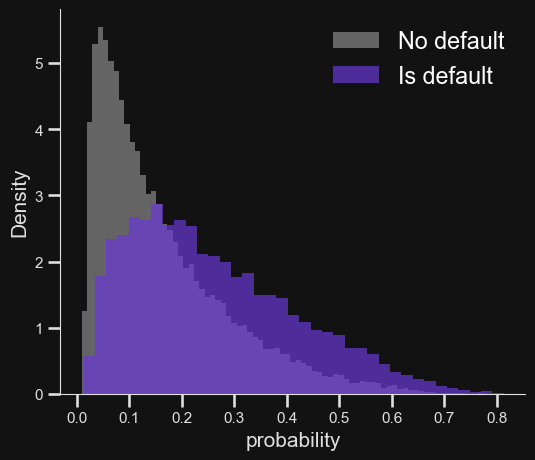

In [ ]:
#realizando a previsão das probabilidades do modelo baseline
y_score = model_baseline.predict_proba(X_test)[:,1] #probabilidade de pertencer a classe default/ind


sns.set_context(rc = {'patch.linewidth': 0.0})
# Função para plotar o histograma das probabilidades preditas
def plot_probabilities_hist(y_score, y_test):
    y_result = pd.DataFrame({
        'probability':  y_score,
        'true_class': y_test,
    })
    fig, ax = plt.subplots(figsize=(6, 5))
    negative = y_result.loc[y_result.true_class == 0, 'probability']
    positive = y_result.loc[y_result.true_class == 1, 'probability']
    sns.histplot(negative, stat='density', color='gray', ax=ax, label='No default')
    sns.histplot(positive, stat='density', color=primary_color, ax=ax, alpha=0.7, label='Is default')
    _ = plt.legend({"No default": negative, "Is default": positive}, fontsize="large")
    sns.despine()
    plt.show()

plot_probabilities_hist(y_score, y_test)

Avg. Precision do modelo baseline 0.38261694558668463
A proporção da classe de interesse (default=1), o baseline da curva do PR é:  0.194885


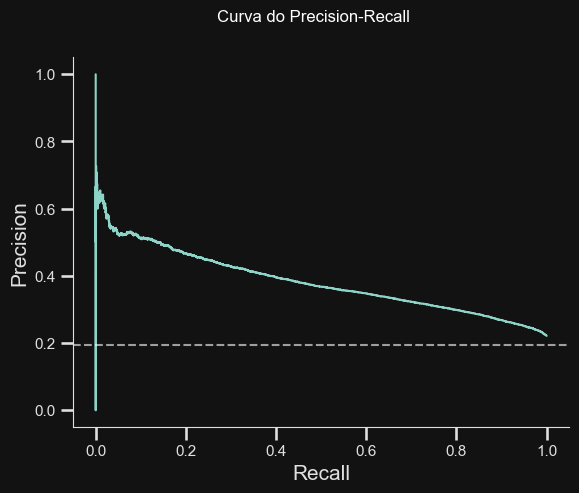

In [ ]:

# Verificando o valor do Avg. Preicision https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
avg_precision = average_precision_score(y_test, y_score)
print('Avg. Precision do modelo baseline', average_precision_score(y_test, y_score))
print('A proporção da classe de interesse (default=1), o baseline da curva do PR é: ', default_ratio)

# Computando o precision e o recall para diferentes thresholds
precision,recall,_ = precision_recall_curve(y_test, y_score)

#Plotando a curva do precision vs recall - comum em classificação binárias
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
title = 'Curva do Precision-Recall'
plt.suptitle(title, y=0.98, fontsize=12)
plt.axhline(default_ratio, linestyle='--', color='white', alpha=0.6)
sns.despine()
plt.show()

## Usando o dataset de teste para calibrar a PD e criar as métriacas de PD, EAD  e LGD

In [ ]:
# Criando a coluna y_score com as probabilidades preditas pelo modelo no dataset de teste
test_df['y_score'] = model_baseline.predict_proba(X_test)[:,1]

In [ ]:
#verificação de valores importantes

test_df[test_df.default == 1][['last_pymnt_amnt', 'mths_since_last_delinq', 'total_pymnt_inv', 'total_pymnt', 'recoveries', 'installment', 'int_rate', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'total_rec_prncp', 'total_rec_int']]

,last_pymnt_amnt,mths_since_last_delinq,total_pymnt_inv,total_pymnt,recoveries,installment,int_rate,loan_amnt,funded_amnt,funded_amnt_inv,term,total_rec_prncp,total_rec_int
52660,476.640015,28,6648.120117,6648.120117,0.000000,476.640015,0.3084,14500,14500,14500.0,60,1721.010010,4927.109863
136500,284.779999,-1,5298.709961,5298.709961,1334.260010,284.779999,0.1806,11200,11200,11200.0,60,1795.609985,2168.840088
15933,430.480011,-1,4565.169922,4565.169922,2002.189941,430.480011,0.2388,15000,15000,15000.0,60,832.340027,1730.640015
162294,298.820007,30,2976.810059,2976.810059,0.000000,298.820007,0.1709,12000,12000,12000.0,60,1364.369995,1612.439941
151137,185.820007,71,863.190002,863.190002,682.929993,185.820007,0.2000,5000,5000,5000.0,36,102.489998,77.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135277,0.000000,-1,0.000000,0.000000,0.000000,778.140015,0.1033,24000,24000,24000.0,36,0.000000,0.000000
20262,0.000000,-1,0.000000,0.000000,0.000000,733.969971,0.1308,32200,32200,32200.0,60,0.000000,0.000000
7922,280.209991,-1,550.969971,550.969971,0.000000,280.209991,0.0756,9000,9000,9000.0,36,448.429993,102.540001
193983,720.020020,-1,2134.389893,2134.389893,0.000000,720.020020,0.1540,30000,30000,30000.0,60,912.690002,1221.699951


In [ ]:
#valor total a ser pago do emprestimo
test_df['principal'] = test_df.loan_amnt*(1+test_df.int_rate)

#exposure at default ratio, percentual do montante total devido em relação ao principal
test_df['ead'] = test_df['principal'] - test_df.total_pymnt
test_df['ead_ratio'] = test_df['ead']/test_df['principal']

#loss given default ratio, percentual de recuperação em relação total devido
test_df['lgd_ratio'] = 1 - test_df['recoveries']/test_df['ead']

#perdas
test_df['losses'] = test_df['principal'] - test_df.total_pymnt+test_df['recoveries']

#tabela para entender os valores e métricas de quem não pagou
test_df[test_df.default == 1][['last_pymnt_amnt', 'mths_since_last_delinq', 'total_pymnt_inv', 'total_pymnt', 'recoveries', 'installment', 'int_rate', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'total_rec_prncp', 'total_rec_int']]

,last_pymnt_amnt,mths_since_last_delinq,total_pymnt_inv,total_pymnt,recoveries,installment,int_rate,loan_amnt,funded_amnt,funded_amnt_inv,term,total_rec_prncp,total_rec_int
52660,476.640015,28,6648.120117,6648.120117,0.000000,476.640015,0.3084,14500,14500,14500.0,60,1721.010010,4927.109863
136500,284.779999,-1,5298.709961,5298.709961,1334.260010,284.779999,0.1806,11200,11200,11200.0,60,1795.609985,2168.840088
15933,430.480011,-1,4565.169922,4565.169922,2002.189941,430.480011,0.2388,15000,15000,15000.0,60,832.340027,1730.640015
162294,298.820007,30,2976.810059,2976.810059,0.000000,298.820007,0.1709,12000,12000,12000.0,60,1364.369995,1612.439941
151137,185.820007,71,863.190002,863.190002,682.929993,185.820007,0.2000,5000,5000,5000.0,36,102.489998,77.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135277,0.000000,-1,0.000000,0.000000,0.000000,778.140015,0.1033,24000,24000,24000.0,36,0.000000,0.000000
20262,0.000000,-1,0.000000,0.000000,0.000000,733.969971,0.1308,32200,32200,32200.0,60,0.000000,0.000000
7922,280.209991,-1,550.969971,550.969971,0.000000,280.209991,0.0756,9000,9000,9000.0,36,448.429993,102.540001
193983,720.020020,-1,2134.389893,2134.389893,0.000000,720.020020,0.1540,30000,30000,30000.0,60,912.690002,1221.699951


In [ ]:
#tabela para entender os valores e métricas de quem pagou
test_df[test_df.default == 0][['term', 'principal', 'installment', 'loan_amnt', 'total_pymnt', 'recoveries', 'ead', 'ead_ratio', 'lgd_ratio', 'losses']]

,term,principal,installment,loan_amnt,total_pymnt,recoveries,ead,ead_ratio,lgd_ratio,losses
179918,60,23288.361752,583.840027,17825,22440.201172,0.0,848.16058,0.03642,1.0,848.16058
188736,36,6903.000355,208.139999,6000,6385.481934,0.0,517.518421,0.07497,1.0,517.518421
95232,36,16102.500558,465.570007,15000,16670.695312,0.0,-568.194755,-0.035286,1.0,-568.194755
106609,36,5032.799721,160.779999,4000,4421.113770,0.0,611.685951,0.12154,1.0,611.685951
43092,36,5902.99964,180.919998,5000,5348.210938,0.0,554.788702,0.093984,1.0,554.788702
...,...,...,...,...,...,...,...,...,...,...
141427,36,2280.400038,68.379997,2000,2015.719971,0.0,264.680067,0.116067,1.0,264.680067
27263,60,11607.999802,243.610001,10000,10044.669922,0.0,1563.32988,0.134677,1.0,1563.32988
74748,36,11388.299704,331.269989,10500,10502.469727,0.0,885.829977,0.077784,1.0,885.829977
183312,36,11607.999802,351.970001,10000,10053.599609,0.0,1554.400192,0.133908,1.0,1554.400192


## Criando as categorias de risco usando o score de predição (quantis)

In [ ]:
test_df['risk_category'], bins = pd.qcut(test_df.y_score, 8, labels=['A','B','C','D','E','F','G','H'], retbins = True)
test_df['risk_category']

179918    G
188736    E
52660     H
95232     B
136500    H
         ..
141427    D
27263     F
74748     A
183312    E
162368    B
Name: risk_category, Length: 40000, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'H']

## Computando as métricas (PD, EAD e LGD) usando as categorias de risco

In [ ]:
#visualizando a coluna target
test_df.default

179918    0.0
188736    0.0
52660     1.0
95232     0.0
136500    1.0
         ... 
141427    0.0
27263     0.0
74748     0.0
183312    0.0
162368    0.0
Name: default, Length: 40000, dtype: float64

In [ ]:
default_table = test_df.groupby(['risk_category', 'term']).agg( # função agg util para mutiplas operações entre as colunas
    default_ratio=('default','mean'),
    int_rate=('int_rate', 'mean'),
    principal=('principal','mean'),
    total=('id', 'count')
).reset_index()

print(default_table)

   risk_category  term  default_ratio  int_rate     principal  total
0              A    36       0.057178  0.071027  15062.091627   4862
1              A    60       0.086957  0.079757  27831.577865    138
2              B    36       0.111569  0.088439  14135.907537   4607
3              B    60       0.122137  0.100411  25024.706361    393
4              C    36       0.140748  0.105308  13870.172681   4334
5              C    60       0.139640  0.109070  26021.472478    666
6              D    36       0.189790  0.123817  13675.928196   4094
7              D    60       0.177704  0.123162  25017.040529    906
8              E    36       0.222511  0.140321  13405.646194   3847
9              E    60       0.231570  0.133831  25689.431172   1153
10             F    36       0.269088  0.158938  13830.852861   3497
11             F    60       0.293883  0.148929  25301.829049   1504
12             G    36       0.312998  0.177469   14881.13978   2885
13             G    60       0.340

In [ ]:
policy_table = test_df[test_df.default == 1].groupby(['risk_category', 'term']).agg(
    EAD=('ead_ratio', 'mean'),
    LGD=('lgd_ratio', 'mean'),
    total_default=('id', 'count'),
    int_rate_default=('int_rate', 'mean'),
).reset_index()

print(policy_table)

policy_table = pd.merge(policy_table, default_table, on =['risk_category', 'term'])
print(policy_table)

   risk_category  term       EAD       LGD  total_default  int_rate_default
0              A    36  0.682892  0.891607            278          0.074318
1              A    60  0.786479  0.978938             12          0.085025
2              B    36  0.645689  0.532034            514          0.093177
3              B    60  0.747898  0.904268             48          0.099631
4              C    36  0.643164  0.917048            610          0.110797
5              C    60  0.752122  0.936136             93          0.112123
6              D    36   0.63692  0.870277            777          0.126292
7              D    60  0.707221   0.46268            161          0.125627
8              E    36  0.631625  0.850597            856          0.143748
9              E    60  0.747914  0.929866            267          0.134967
10             F    36  0.633642  0.818412            941          0.161657
11             F    60  0.728874  0.901818            442          0.153597
12          

In [ ]:
#tabela com as metricas para a politica de emprestimos de 3 anos
policy_3 = policy_table.loc[policy_table.term==36].copy()

#tabela com as métricas para a politica de emprestimos de 5 anos
policy_5 = policy_table.loc[policy_table.term==60].copy()


In [ ]:
policy_3

,risk_category,term,EAD,LGD,total_default,int_rate_default,default_ratio,int_rate,principal,total
0,A,36,0.682892,0.891607,278,0.074318,0.057178,0.071027,15062.091627,4862
2,B,36,0.645689,0.532034,514,0.093177,0.111569,0.088439,14135.907537,4607
4,C,36,0.643164,0.917048,610,0.110797,0.140748,0.105308,13870.172681,4334
6,D,36,0.63692,0.870277,777,0.126292,0.189790,0.123817,13675.928196,4094
8,E,36,0.631625,0.850597,856,0.143748,0.222511,0.140321,13405.646194,3847
10,F,36,0.633642,0.818412,941,0.161657,0.269088,0.158938,13830.852861,3497
12,G,36,0.649715,0.884711,903,0.179419,0.312998,0.177469,14881.13978,2885
14,H,36,0.657489,0.895965,611,0.204665,0.411725,0.201285,16523.74656,1484


In [ ]:
policy_5

,risk_category,term,EAD,LGD,total_default,int_rate_default,default_ratio,int_rate,principal,total
1,A,60,0.786479,0.978938,12,0.085025,0.086957,0.079757,27831.577865,138
3,B,60,0.747898,0.904268,48,0.099631,0.122137,0.100411,25024.706361,393
5,C,60,0.752122,0.936136,93,0.112123,0.139640,0.109070,26021.472478,666
7,D,60,0.707221,0.46268,161,0.125627,0.177704,0.123162,25017.040529,906
9,E,60,0.747914,0.929866,267,0.134967,0.231570,0.133831,25689.431172,1153
11,F,60,0.728874,0.901818,442,0.153597,0.293883,0.148929,25301.829049,1504
13,G,60,0.712117,0.897672,720,0.173487,0.340587,0.169922,24739.48097,2114
15,H,60,0.699487,0.886932,1622,0.212422,0.461320,0.206898,24648.093754,3516


## Fórmula da taxa de juros mínima da politica de crédito
𝑅𝑂𝐼=𝑛𝑒𝑡𝑝𝑟𝑜𝑓𝑖𝑡/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡
𝑛𝑒𝑡𝑝𝑟𝑜𝑓𝑖𝑡/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡>=0.025∗𝑡𝑒𝑟𝑚
(𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡∗𝐼𝑅−𝐸𝐴𝐷∗𝐿𝐺𝐷∗𝑃(𝐷)∗(1+𝐼𝑅)∗𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡−𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒)/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡>=0.025∗𝑡𝑒𝑟𝑚
(𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡∗[𝐼𝑅−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)∗(1+𝐼𝑅))/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡−𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡>=0.025∗𝑡𝑒𝑟𝑚
𝐼𝑅−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)∗(1+𝐼𝑅)−𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡>=0.025∗𝑡𝑒𝑟𝑚
𝐼𝑅−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)∗𝐼𝑅−𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡>=0.025∗𝑡𝑒𝑟𝑚
𝐼𝑅−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)∗𝐼𝑅>=0.025∗𝑡𝑒𝑟𝑚+𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡
𝐼𝑅−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)∗𝐼𝑅>=0.025∗𝑡𝑒𝑟𝑚+𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡
𝐼𝑅−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)∗𝐼𝑅>=0.025∗𝑡𝑒𝑟𝑚+𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡+𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)
𝐼𝑅(1−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠))>=0.025∗𝑡𝑒𝑟𝑚+𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡+𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)
𝐼𝑅>=0.025∗𝑡𝑒𝑟𝑚+𝑐𝑜𝑠𝑡𝑠𝑓𝑒𝑒/𝑙𝑜𝑎𝑛𝑎𝑚𝑛𝑡+𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)1−𝐸(𝑙𝑜𝑠𝑠𝑒𝑠)

## Criando politica de crédito

In [ ]:
#tempo do empréstimo ira influenciar nas métricas de empréstismo
# afunção abaixo vai calcular o ROI sobre condições de empréstimo

def compute_roi(int_rate, loan_amnt, default_prob, EAD, LGD, loan_fees, term_years):
    EAD_LGD = EAD*LGD
    principal = (1 + int_rate)*loan_amnt
    expected_loss = principal*EAD_LGD*default_prob
    profit = (int_rate*loan_amnt)
    net_profit = profit - expected_loss - loan_fees*loan_amnt
    ROI = net_profit/loan_amnt
    ROI_annualized = ROI/term_years

    return {
        'ROI': ROI,
        'ROI_annualized': ROI_annualized,
        'principal': principal,
        'expected_loss': expected_loss,
        'profit': profit,
        'net_profit': net_profit,
        'default_prob': default_prob,
        'EAD': EAD,
        'LGD': LGD
    }

compute_roi(int_rate=0.10, loan_amnt=50000, default_prob=0.14, EAD=0.2, LGD=0.87, loan_fees=0.002, term_years=3)

{'ROI': 0.07120399999999999,
 'ROI_annualized': 0.023734666666666664,
 'principal': 55000.00000000001,
 'expected_loss': 1339.8000000000004,
 'profit': 5000.0,
 'net_profit': 3560.2,
 'default_prob': 0.14,
 'EAD': 0.2,
 'LGD': 0.87}

In [ ]:
#função de calculo de melhor taxa de juros baseado no ROI
def compute_best_interest_rate(term_years, expected_losses, loan_fees, ir_constraint=0.025):
    best_ir = (0.025*term_years + expected_losses + loan_fees)/(1 - expected_losses)
    return best_ir


def compute_policy_interest_rate(loan_amnt, loan_fees, risk, policy_table):
    term_months = policy_3.term.iloc[0]
    term_years = term_months/12

    default_prob = policy_table.loc[policy_table.risk_category == risk, 'default_ratio'].item()
    EAD = policy_table.loc[policy_table.risk_category == risk, 'EAD'].item()
    LGD = policy_table.loc[policy_table.risk_category == risk, 'LGD'].item()

    expected_losses = EAD*LGD*default_prob
    best_ir = compute_best_interest_rate(term_years, expected_losses, loan_fees)

    roi_return = compute_roi(best_ir, loan_amnt, default_prob, EAD, LGD, loan_fees, term_years)

    policy_ret = {'best_interest_rate': best_ir}
    policy_ret.update(roi_return)

    return policy_ret

compute_policy_interest_rate(50000, 0.002, 'B',  policy_3)

{'best_interest_rate': 0.11992360372007702,
 'ROI': 0.07500000000000001,
 'ROI_annualized': 0.025000000000000005,
 'principal': 55996.180186003854,
 'expected_loss': 2146.18018600385,
 'profit': 5996.18018600385,
 'net_profit': 3750.0000000000005,
 'default_prob': 0.11156935098762752,
 'EAD': 0.6456892475674417,
 'LGD': 0.5320339149476997}

In [ ]:
test_df['credit_policy_interest_rate'] = test_df.apply(
    lambda row: compute_policy_interest_rate(row['loan_amnt'], loan_fees=0.002, risk=row['risk_category'], policy_table=policy_3)['best_interest_rate'],
    axis=1
)

In [ ]:
df_gp = test_df.groupby(['default', 'term']).agg(
    credit_policy_interest_rate_mean=('credit_policy_interest_rate','mean'),
    credit_policy_interest_rate_std=('credit_policy_interest_rate','std'),
).reset_index().sort_values('term')
df_gp


,default,term,credit_policy_interest_rate_mean,credit_policy_interest_rate_std
0,0.0,36,0.192673,0.075289
2,1.0,36,0.241722,0.086163
1,0.0,60,0.285896,0.096995
3,1.0,60,0.337835,0.089467


<Axes: xlabel='term', ylabel='credit_policy_interest_rate_mean'>

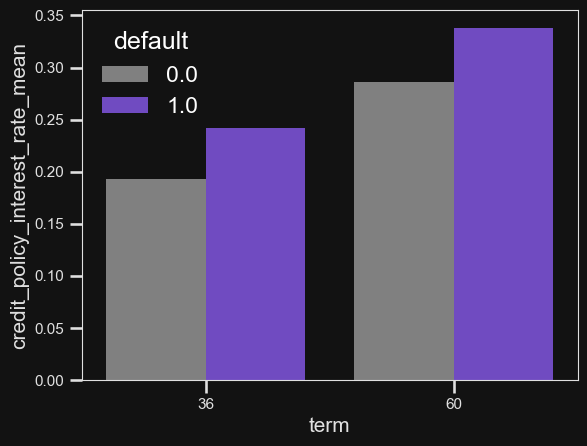

In [ ]:
sns.barplot(data=df_gp, x="term", y="credit_policy_interest_rate_mean", hue="default", palette=['gray', primary_color])